<a href="https://colab.research.google.com/github/ashleyngomez380/Project1/blob/main/Li_GroupDRO_clean_sep22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!git clone https://github.com/ashleyngomez380/Project1.git

fatal: destination path 'Project1' already exists and is not an empty directory.


In [30]:
!cp -r Project1/* /content/

#Functions and Code

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import argparse
import warnings
import os, sys
import time
from scipy import stats


'''
How to use main.py


'''

parser = argparse.ArgumentParser()


# dataset settings
parser.add_argument('--x_len', type=int, default=480,
                    help='input sequence length')

parser.add_argument('--y_len', type=int, default=96,
                    help='output sequence length')

parser.add_argument('--group_idx', type=str, default="weekend_label.txt",
                    help='group label file e.g. weekend_label.txt')

parser.add_argument('--model', type=str, default="tmp.pt",
                    help='saved model name')

parser.add_argument('--board', type=str, default="run2",
                    help='saved model name')

parser.add_argument('--dataset', type=str, default="dutch_power_demand.txt",
                    help='time series file e.g: dutch_power_demand.txt')

parser.add_argument('--split', type=str, default="10000,20000,30000",
                    help='split of train/vaild/test data e.g. 10000/20000/30000 (training: 0 10000, vaildation: 10000,20000, testing: 20000 30000)')

parser.add_argument('--d', type=int, default=1,
                    help='dimension of time series')

parser.add_argument('--delta', type=float, default=0.1,
                    help='dimension of time series')


parser.add_argument('--batch_size', type=int, default=128,
                    help='batch size')

parser.add_argument('--epoch_size', type=int, default=20,
                    help='epochs')

parser.add_argument('--step_size', type=float, default=1,
                    help='step size')

parser.add_argument('--no_dro', action='store_true', default=False,
                    help='Do not use dro. Default:False')

parser.add_argument('--wd', type=float, default=0,
                    help='Weight decay (L2 loss on parameters). default: 0')

args = parser.parse_args('')

args.split = [int(s) for s in args.split.split(",")]

print(args.no_dro)


class LossComputer:
    def __init__(self, criterion, n_groups, group_counts, alpha=None,gamma=0.1, is_robust=True, adj=None, min_var_weight=0, step_size=1, normalize_loss=False, btl=False):
        self.criterion = criterion
        self.is_robust = is_robust
        self.gamma = gamma
        self.alpha = alpha
        self.min_var_weight = min_var_weight
        self.step_size = step_size
        self.normalize_loss = normalize_loss
        self.btl = btl

        self.n_groups = n_groups
        self.group_counts = group_counts.cuda()
        self.group_frac = self.group_counts/self.group_counts.sum()
        #self.group_str = dataset.group_str

        if adj is not None:
            self.adj = torch.from_numpy(adj).float().cuda()
        else:
            self.adj = torch.zeros(self.n_groups).float().cuda()

        if is_robust:
            assert alpha, 'alpha must be specified'

        # quantities maintained throughout training
        self.adv_probs = torch.ones(self.n_groups).cuda()/self.n_groups
        self.exp_avg_loss = torch.zeros(self.n_groups).cuda()
        self.exp_avg_initialized = torch.zeros(self.n_groups).byte().cuda()

        self.reset_stats()

    def loss(self, yhat, y, group_idx=None, is_training=False):
        # compute per-sample and per-group losses
        per_sample_losses = self.criterion(yhat, y)
        #per_sample_losses = per_sample_losses.sum(dim=2).squeeze()
        group_loss, group_count = self.compute_group_avg(per_sample_losses, group_idx)
        print(group_loss)
        #group_count = self.compute_group_avg((torch.argmax(yhat,1)==y).float(), group_idx)
        #print(group_count)
        # update historical losses
        #self.update_exp_avg_loss(group_loss, group_count)

        # compute overall loss
        if self.is_robust and not self.btl:
            actual_loss, weights = self.compute_robust_loss(group_loss, group_count)
        elif self.is_robust and self.btl:
             actual_loss, weights = self.compute_robust_loss_btl(group_loss, group_count)
        else:
            actual_loss = per_sample_losses.mean()
            weights = None

        # update stats
        #self.update_stats(actual_loss, group_loss, group_count, weights)

        return actual_loss

    def compute_robust_loss(self, group_loss, group_count):
        adjusted_loss = group_loss
        if torch.all(self.adj>0):
            adjusted_loss += self.adj/torch.sqrt(self.group_counts)
        if self.normalize_loss:
            adjusted_loss = adjusted_loss/(adjusted_loss.sum())

        s = torch.exp(self.step_size*adjusted_loss.data);
        #s[0]=0.9;
        #print(s)

        self.adv_probs = self.adv_probs * s

        #self.adv_probs[0] = 0.05
        self.adv_probs = self.adv_probs/(self.adv_probs.sum())
        #print("original prob")
        #print(self.adv_probs )

        if self.adv_probs[0]>args.delta:
           # print('revised prob')
            self.adv_probs[0] = self.adv_probs[0]/self.n_groups
           # print(self.adv_probs)
            self.adv_probs = self.adv_probs/(self.adv_probs.sum())

        print(self.adv_probs)
        robust_loss = group_loss @ self.adv_probs
        return robust_loss, self.adv_probs

    def compute_robust_loss_btl(self, group_loss, group_count):
        adjusted_loss = self.exp_avg_loss + self.adj/torch.sqrt(self.group_counts)
        return self.compute_robust_loss_greedy(group_loss, adjusted_loss)

    def compute_robust_loss_greedy(self, group_loss, ref_loss):
        sorted_idx = ref_loss.sort(descending=True)[1]
        sorted_loss = group_loss[sorted_idx]
        sorted_frac = self.group_frac[sorted_idx]

        mask = torch.cumsum(sorted_frac, dim=0)<=self.alpha
        weights = mask.float() * sorted_frac /self.alpha
        last_idx = mask.sum()
        weights[last_idx] = 1 - weights.sum()
        weights = sorted_frac*self.min_var_weight + weights*(1-self.min_var_weight)

        robust_loss = sorted_loss @ weights

        # sort the weights back
        _, unsort_idx = sorted_idx.sort()
        unsorted_weights = weights[unsort_idx]
        return robust_loss, unsorted_weights

    '''
    def compute_group_avg(self, losses, group_idx):
        # compute observed counts and mean loss for each group
        group_map = (group_idx == torch.arange(self.n_groups).unsqueeze(1).long().cuda()).float()
        group_count = group_map.sum(1)
        group_denom = group_count + (group_count==0).float() # avoid nans
        #print(group_denom.size())
        #print(group_map.size())
        #print(losses.view(-1).size())
        group_loss = (group_map @ losses.view(-1))/group_denom
        return group_loss, group_count
    '''

    def compute_group_avg(self, losses, group_idx):
        # compute observed counts and mean loss for each group
        group_map = (group_idx == torch.arange(self.n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()

        group_count = group_map.sum(1).sum(1)
        group_denom = group_count + (group_count==0).float() # avoid nans
        #print(group_denom.size())
        #print(group_map.size())
        #print(losses.view(-1).size())
        group_loss = torch.einsum('bj,gbj->g', losses, group_map.float()).squeeze()/group_denom
        return group_loss, group_count


    def update_exp_avg_loss(self, group_loss, group_count):
        prev_weights = (1 - self.gamma*(group_count>0).float()) * (self.exp_avg_initialized>0).float()
        curr_weights = 1 - prev_weights
        self.exp_avg_loss = self.exp_avg_loss * prev_weights + group_loss*curr_weights
        self.exp_avg_initialized = (self.exp_avg_initialized>0) + (group_count>0)

    def reset_stats(self):
        self.processed_data_counts = torch.zeros(self.n_groups).cuda()
        self.update_data_counts = torch.zeros(self.n_groups).cuda()
        self.update_batch_counts = torch.zeros(self.n_groups).cuda()
        self.avg_group_loss = torch.zeros(self.n_groups).cuda()
        self.avg_group_acc = torch.zeros(self.n_groups).cuda()
        self.avg_per_sample_loss = 0.
        self.avg_actual_loss = 0.
        #self.avg_acc = 0.
        self.batch_count = 0.

    def update_stats(self, actual_loss, group_loss, group_count, weights=None):
        # avg group loss
        denom = self.processed_data_counts + group_count
        denom += (denom==0).float()
        prev_weight = self.processed_data_counts/denom
        curr_weight = group_count/denom
        self.avg_group_loss = prev_weight*self.avg_group_loss + curr_weight*group_loss

        # avg group acc
        #self.avg_group_acc = prev_weight*self.avg_group_acc + curr_weight*group_acc

        # batch-wise average actual loss
        denom = self.batch_count + 1
        self.avg_actual_loss = (self.batch_count/denom)*self.avg_actual_loss + (1/denom)*actual_loss

        # counts
        self.processed_data_counts += group_count
        if self.is_robust:
            self.update_data_counts += group_count*((weights>0).float())
            self.update_batch_counts += ((group_count*weights)>0).float()
        else:
            self.update_data_counts += group_count
            self.update_batch_counts += (group_count>0).float()
        self.batch_count+=1

        # avg per-sample quantities
        group_frac = self.processed_data_counts/(self.processed_data_counts.sum())
        self.avg_per_sample_loss = group_frac @ self.avg_group_loss
        #self.avg_acc = group_frac @ self.avg_group_acc

    def get_model_stats(self, model, args, stats_dict):
        model_norm_sq = 0.
        for param in model.parameters():
            model_norm_sq += torch.norm(param) ** 2
        stats_dict['model_norm_sq'] = model_norm_sq.item()
        stats_dict['reg_loss'] = args.weight_decay / 2 * model_norm_sq.item()
        return stats_dict

    def get_stats(self, model=None, args=None):
        stats_dict = {}
        for idx in range(self.n_groups):
            stats_dict[f'avg_loss_group:{idx}'] = self.avg_group_loss[idx].item()
            stats_dict[f'exp_avg_loss_group:{idx}'] = self.exp_avg_loss[idx].item()
            stats_dict[f'avg_acc_group:{idx}'] = self.avg_group_acc[idx].item()
            stats_dict[f'processed_data_count_group:{idx}'] = self.processed_data_counts[idx].item()
            stats_dict[f'update_data_count_group:{idx}'] = self.update_data_counts[idx].item()
            stats_dict[f'update_batch_count_group:{idx}'] = self.update_batch_counts[idx].item()

        stats_dict['avg_actual_loss'] = self.avg_actual_loss.item()
        stats_dict['avg_per_sample_loss'] = self.avg_per_sample_loss.item()
        #stats_dict['avg_acc'] = self.avg_acc.item()

        # Model stats
        if model is not None:
            assert args is not None
            stats_dict = self.get_model_stats(model, args, stats_dict)

        return stats_dict

    def log_stats(self, logger, is_training):
        if logger is None:
            return

        logger.write(f'Average incurred loss: {self.avg_per_sample_loss.item():.3f}  \n')
        logger.write(f'Average sample loss: {self.avg_actual_loss.item():.3f}  \n')
        #logger.write(f'Average acc: {self.avg_acc.item():.3f}  \n')
        for group_idx in range(self.n_groups):
            logger.write(
                f'  {self.group_str(group_idx)}  '
                f'[n = {int(self.processed_data_counts[group_idx])}]:\t'
                f'loss = {self.avg_group_loss[group_idx]:.3f}  '
                f'exp loss = {self.exp_avg_loss[group_idx]:.3f}  '
                f'adv prob = {self.adv_probs[group_idx]:3f}  ')
        logger.flush()




class Syn_Dataset_Simple2(Dataset):
    def __init__(self, x_train, y_train, y_class):
        self.x_train = x_train
        self.y_train = y_train
        self.y_class = y_class

    def __getitem__(self, index):
        seq_x, seq_y, seq_x_mark, seq_y_mark = self.read_instance(self.x_train, self.y_train, self.y_class, index)
        return seq_x, seq_y, seq_x_mark, seq_y_mark, index

    def __len__(self):
        return self.x_train.shape[0]

    def read_instance(self, x, y, y_class, index):
        seq_x = x[index,:]
        seq_y = y[index,:]

        # covariates
        seq_x_mark = np.array(np.arange(0,seq_x.size(1)))
        #seq_y_mark = np.array(np.arange(0,seq_y.size(1)))
        seq_y_mark = y_class[index,:]
        return seq_x, seq_y, seq_x_mark, seq_y_mark


class Syn_Dataset_Simple(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def __getitem__(self, index):
        seq_x, seq_y, seq_x_mark, seq_y_mark = self.read_instance(self.x_train, self.y_train, index)
        return seq_x, seq_y, seq_x_mark, seq_y_mark, index

    def __len__(self):
        return self.x_train.shape[0]

    def read_instance(self, x, y, index):
        seq_x = x[index,:]
        seq_y = y[index,:]
        # covariates
        seq_x_mark = np.array(np.arange(0,seq_x.size(1)))
        seq_y_mark = np.array(np.arange(0,seq_y.size(1)))
        return seq_x, seq_y, seq_x_mark, seq_y_mark


def train_test_convert(data, x_len, y_len, normalize=False):
    if normalize:
        data = stats.zscore(data)

    import numpy.lib.stride_tricks as st
    X = st.sliding_window_view(data, x_len+y_len)
    X = torch.from_numpy(X).unsqueeze(1)
    x_train = X[:,:,0:x_len].float()
    y_train = X[:,:,x_len:].float()

    return x_train, y_train

def compute_instwise_mse(out,y_test):
    mse = nn.MSELoss(reduction='none')
    ts = mse(out,y_test).mean(dim=2).cpu().detach().numpy()
    #plt.plot(mse(out,y_test).mean(dim=2).cpu().detach().numpy())
    return ts

def stepwise_mse_loss(out,y_test,x_len,y_len):
    loss_stepwise = torch.zeros((out.size(0)+x_len+y_len-1))
    mse = nn.MSELoss(reduction='none')
    ts_loss = mse(out,y_test)
    for i in range(ts_loss.size(0)):
        loss_stepwise[i+x_len:i+x_len+y_len]=loss_stepwise[i+x_len:i+x_len+y_len]+ts_loss[i,0,:]/y_len
    return loss_stepwise.detach().cpu().numpy()

def evals(model,test_loader):
    #data = Syn_Dataset_Simple(X,y)
    #test_loader = DataLoader(data, batch_size=32, shuffle=False, drop_last=False)
    model.eval()
    preds = []
    for data in test_loader:
        batch_x,batch_y,batch_x_mark,batch_y_mark,batch_idx = data
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x_mark = torch.tensor(batch_x_mark).float().cuda()
        batch_y_placeholder = torch.zeros_like(batch_y).float().cuda()
        batch_y_mark = torch.tensor(batch_y_mark).float().cuda()
        outputs= model(batch_x.float(), batch_x_mark, batch_y_placeholder, batch_y_mark)
        preds.append(outputs.cpu().detach())
    pred = torch.cat(preds)
    return pred

def tensorboard_plot(writer,label,o,y):
    t = o.cpu().detach().numpy()
    gt = y.cpu().detach().numpy()


def plot_loss_per_instance(ts):
    fig = plt.figure(figsize=(24, 24))
    plt.plot(ts)
    plt.ylim([0,3.5])
    return fig








False


#Model

In [32]:
import torch.nn.functional as F
# model input is strictly enforced as (B x C x T). Output size is strictly enforced as (B x T)
class MLP(nn.Module):
  def __init__(self, input_size, channel_size,hidden_size, output_size):
    super(MLP, self).__init__()
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(input_size*channel_size, hidden_size) # First layer
    self.relu = nn.ReLU() # relu activation function
    self.fc2 = nn.Linear(hidden_size, output_size) # Second layer

  # Forward is equivalent to the first equation in the paper
  def forward(self, x):
    x = self.flat(x)
    x = self.fc1(x) # we take the output of layer 1 (fc1)
    x = self.relu(x) # run the output through the relu activation
    x = self.fc2(x) # then run that throught the last layer
    return x

# split data and save mean, sd.
predict_window_size = 24
train_window_size = 96
hidden_size = 128
channel_size = 1


model = MLP(train_window_size, channel_size, hidden_size, predict_window_size).cuda()

#Dataset

In [33]:
import pandas as pd

# Read the CSV file
datapd = pd.read_csv('/content/Sep18/normaldutchPowerDataF1Label.csv')

# Convert to NumPy array
data= datapd.to_numpy()

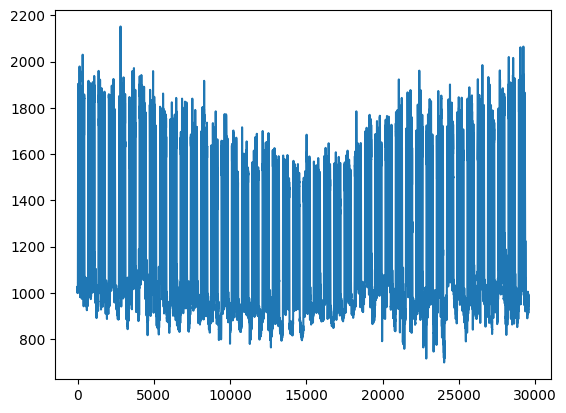

In [34]:
plt.plot(data[:,0])

In [35]:
data[:, [0, 1]] = data[:, [1, 0]]


In [36]:
data = data.astype('float')

In [37]:
# prompt: normalize by mean and standard deviation to data[:, 1]

# Calculate mean and standard deviation
mean = np.mean(data[:, 1])
std = np.std(data[:, 1])

# Normalize the data
normalized_data = (data[:, 1] - mean) / std

# Replace the original data with the normalized data
data[:, 1] = normalized_data


In [38]:
np.save('cleaned_dutch_power.npy',data)

In [39]:
# data = np.loadtxt('demo_data_price.csv',delimiter=',')

In [40]:
# Split the time series into training, validation and testing series
train_portion = 0.48
vali_portion = 0.4
test_portion = 1- train_portion - vali_portion

train_size = np.ceil(train_portion*data.shape[0]).astype('int')
vali_size = np.ceil(vali_portion*data.shape[0]).astype('int')

data_train = data[:train_size,:]
data_validation = data[train_size:train_size+vali_size,:]
data_test = data[train_size+vali_size:,:]

def normalize_data(data):
    return data,0,0
'''
def normalize_data(data):
    # Calculate the mean and standard deviation along each dimension
    means = data.mean(dim=0)
    stds = data.std(dim=0)

    # Avoid division by zero by adding a small constant to std if necessary
    stds += 1e-8

    # Normalize the data
    normalized_data = (data - means) / stds

    # Assuming 'data' is your multivariate time series dataset in a PyTorch tensor
    # Compute the minimum and maximum values for each feature
    #min_vals, _ = torch.min(data, dim=0)
    #max_vals, _ = torch.max(data, dim=0)

    # Apply min-max scaling to normalize the data
    #normalized_data = (data - min_vals) / (max_vals - min_vals) + 1e-8
    return normalized_data, means, stds
    #return normalized_data, min_vals, max_vals
'''

def generate_forecast_data(train_data,train_window_size=750,predict_window_size = 200):
  train_data = torch.from_numpy(train_data)
  train_data,mean_data, std_data = normalize_data(train_data)
  data_segments = train_data.unfold(dimension = 0,size = train_window_size, step = 1).float()
  target_data = train_data[train_window_size:]
  target_data_segments = target_data.unfold(dimension = 0,size = predict_window_size, step = 1).float()
  data_segments = data_segments[0:target_data_segments.size(0),:]
  target_data_segments = target_data_segments[:,[0,-1],:]
  return data_segments, target_data_segments, mean_data, std_data



train,target,mean_data, std_data = generate_forecast_data(data_train,train_window_size=train_window_size, predict_window_size=predict_window_size)
test,target_test,mean_data2, std_data2 = generate_forecast_data(data_test,train_window_size=train_window_size, predict_window_size=predict_window_size)

# add validation and validation target ect.
validation,target_validation,mean_data3,std_data3 = generate_forecast_data(data_validation,train_window_size=train_window_size, predict_window_size=predict_window_size)


# Convert data to PyTorch tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

# make the new validations into tensors
validation_tensor = torch.tensor(validation, dtype=torch.float32)
target_validation_tensor = torch.tensor(target_validation, dtype=torch.float32)



train_y = target_tensor.cuda()
train_X = train_tensor.cuda()
valid_X = validation_tensor.cuda()
valid_y = target_validation_tensor.cuda()
test_X = test_tensor.cuda()
test_Y = target_test_tensor.cuda()

train_g = train_y[:,0,:].int()
valid_g = valid_y[:,0,:].int()
test_g = test_Y[:,0,:].int()

train_X = train_X[:,1:,:]
valid_X = valid_X[:,1:,:]
test_X = test_X[:,1:,:]
train_y = train_y[:,1,:]
valid_y = valid_y[:,1,:]
test_y = test_Y[:,1,:]

unique_label, group_counts = torch.unique(train_g, return_counts=True)
n_groups = len(unique_label)


<ipython-input-40-b6a2f30c9dcb>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(train, dtype=torch.float32)
<ipython-input-40-b6a2f30c9dcb>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(test, dtype=torch.float32)
<ipython-input-40-b6a2f30c9dcb>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.float32)
<ipython-input-40-b6a2f30c9dcb>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

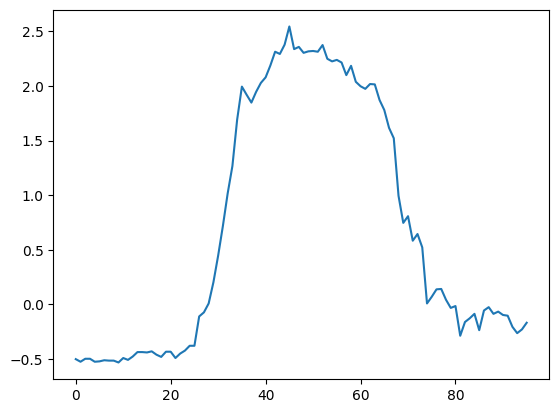

In [41]:
plt.plot(train_X[0, 0, :].cpu().numpy())

In [42]:
test_X.size()

torch.Size([3428, 1, 96])

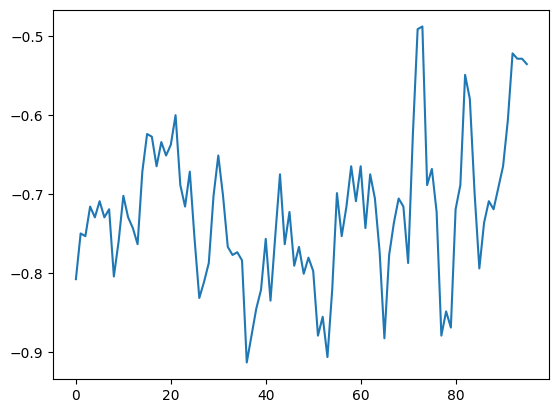

In [43]:
plt.plot(test_X[100, 0, :].cpu().numpy())

In [44]:
# prompt: create a pytorch dataset class for storing train_X, train_y, train_g together

class TS_Group_Dataset(Dataset):
  def __init__(self, X, y, g):
    self.X = X
    self.y = y
    self.g = g

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx], self.g[idx]


In [45]:
train_dataset = TS_Group_Dataset(train_X, train_y, train_g)
test_dataset = TS_Group_Dataset(test_X, test_y, test_g)
valid_dataset = TS_Group_Dataset(valid_X, valid_y, valid_g)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#Model Training

In [46]:
criterion =  nn.MSELoss(reduction='none')
criterion2 = nn.MSELoss()


In [47]:
print(train_window_size)
print(channel_size)
print(hidden_size)
print(predict_window_size)


96
1
128
24


# Group DRO

In [48]:
# claim the model
model = MLP(train_window_size, channel_size, hidden_size, predict_window_size).cuda()
model_optim = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)

In [49]:
model = model.cuda()
adv_probs = torch.ones(n_groups).cuda()/n_groups

In [50]:
# prompt: training the model use train, verify by vaildation, and report test result
# this is DRO
n_epochs = 50
best_valid_loss = float('inf')
counter = 0

for epoch in range(n_epochs):
  model.train()
  train_loss = 0
  for batch_X, batch_y, batch_g in train_loader:
    model.train()
    model_optim.zero_grad()

    outputs = model(batch_X) # model will output a forecasting
    loss = criterion(outputs, batch_y)

    group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
    group_count = group_map.sum(1).sum(1)
    group_denom = group_count + (group_count==0).float() # avoid nans
    group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
    group_loss = group_loss/group_denom

    adjusted_loss = group_loss
    adjusted_loss = adjusted_loss/(adjusted_loss.sum())

    s = torch.exp(adjusted_loss.data);
    adv_probs = adv_probs * s
    adv_probs = (adv_probs+1)/(adv_probs.sum()+1)
    robust_loss = group_loss @ adv_probs
    robust_loss.backward()
    # optimize the params based off the loss
    model_optim.step()
    train_loss += robust_loss.item()

  model.eval()
  valid_loss = 0
  with torch.no_grad():
    for batch_X, batch_y, batch_g in valid_loader:
      outputs = model(batch_X)
      loss = criterion(outputs, batch_y)
      group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
      group_count = group_map.sum(1).sum(1)
      group_denom = group_count + (group_count==0).float() # avoid nans
      group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
      group_loss = group_loss/group_denom
      loss_avg = group_loss.mean()
      valid_loss += loss_avg.item()
  test_loss = 0

  with torch.no_grad():
    for batch_X, batch_y, batch_g in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
        group_count = group_map.sum(1).sum(1)
        group_denom = group_count + (group_count==0).float() # avoid nans
        group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
        group_loss = group_loss/group_denom
        loss_avg = group_loss.mean()
        test_loss += loss_avg.item()

  print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Test Running Los: {:.4f}'
        .format(epoch+1, n_epochs, train_loss / len(train_loader), valid_loss / len(valid_loader),test_loss / len(test_loader)))

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')


# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test set
model.eval()
test_loss = 0
group_loss_tmp = np.zeros((2,))

with torch.no_grad():
  for batch_X, batch_y, batch_g in test_loader:
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
    group_count = group_map.sum(1).sum(1)
    group_denom = group_count + (group_count==0).float() # avoid nans
    group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
    group_loss = group_loss/group_denom
    group_loss_tmp += group_loss.cpu().detach().numpy()
    loss_avg = group_loss.mean()
    test_loss += loss_avg.item()


print('DRO Test Loss: {:.4f}'.format(test_loss / len(test_loader)))
final_group_loss = group_loss_tmp / len(test_loader)
print('DRO Group Test Loss: ' + str(final_group_loss))


Epoch [1/50], Train Loss: 0.4298, Valid Loss: 0.1215, Test Running Los: 0.1825
Epoch [2/50], Train Loss: 0.2557, Valid Loss: 0.1051, Test Running Los: 0.1576
Epoch [3/50], Train Loss: 0.2291, Valid Loss: 0.1045, Test Running Los: 0.1527
Epoch [4/50], Train Loss: 0.2226, Valid Loss: 0.1020, Test Running Los: 0.1489
Epoch [5/50], Train Loss: 0.2144, Valid Loss: 0.0964, Test Running Los: 0.1435
Epoch [6/50], Train Loss: 0.2063, Valid Loss: 0.0975, Test Running Los: 0.1409
Epoch [7/50], Train Loss: 0.2041, Valid Loss: 0.0983, Test Running Los: 0.1381
Epoch [8/50], Train Loss: 0.2012, Valid Loss: 0.0976, Test Running Los: 0.1373
Epoch [9/50], Train Loss: 0.1995, Valid Loss: 0.0948, Test Running Los: 0.1380
Epoch [10/50], Train Loss: 0.1991, Valid Loss: 0.0940, Test Running Los: 0.1380
Epoch [11/50], Train Loss: 0.1977, Valid Loss: 0.0924, Test Running Los: 0.1327
Epoch [12/50], Train Loss: 0.1897, Valid Loss: 0.0925, Test Running Los: 0.1387
Epoch [13/50], Train Loss: 0.1956, Valid Loss: 0.

<ipython-input-50-3699cd322ede>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


### Regular RMSE

In [51]:
model = MLP(train_window_size, channel_size, hidden_size, predict_window_size).cuda()
model_optim = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)

In [ ]:
# prompt: training model via criterion2
# this is RMSE
n_epochs = 50
best_valid_loss = float('inf')
patience = 100
counter = 0

for epoch in range(n_epochs):
  model.train()
  train_loss = 0
  for batch_X, batch_y, batch_g in train_loader:
    model.train()
    model_optim.zero_grad()

    outputs = model(batch_X) # model will output a forecasting
    loss = criterion2(outputs, batch_y) # Use criterion2 here

    loss.backward()
    # optimize the params based off the loss
    model_optim.step()
    train_loss += loss.item()

  model.eval()
  valid_loss = 0
  with torch.no_grad():
    for batch_X, batch_y, batch_g in valid_loader:
      outputs = model(batch_X)
      loss = criterion2(outputs, batch_y) # Use criterion2 here
      valid_loss += loss.item()



  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model_rmse.pth')

  test_loss = 0
  group_loss_tmp = np.zeros((2,))

  with torch.no_grad():
    for batch_X, batch_y, batch_g in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
        group_count = group_map.sum(1).sum(1)
        group_denom = group_count + (group_count==0).float() # avoid nans
        group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
        group_loss = group_loss/group_denom
        loss_avg = group_loss.mean()
        test_loss += loss_avg.item()
  print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Test Running Los: {:.4f}'
        .format(epoch+1, n_epochs, train_loss / len(train_loader), valid_loss / len(valid_loader),test_loss / len(test_loader)))

model.load_state_dict(torch.load('best_model_rmse.pth'))

model.eval()

test_loss = 0
with torch.no_grad():
  for batch_X, batch_y, batch_g in test_loader:
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    group_map = (batch_g == torch.arange(n_groups).unsqueeze(1).unsqueeze(1).long().cuda()).float()
    group_count = group_map.sum(1).sum(1)
    group_denom = group_count + (group_count==0).float() # avoid nans
    group_loss = torch.einsum('bj,gbj->g', loss, group_map.float()).squeeze()
    group_loss = group_loss/group_denom
    group_loss_tmp += group_loss.cpu().detach().numpy()
    loss_avg = group_loss.mean()
    test_loss += loss_avg.item()
print('RMSE Test Loss: {:.4f}'.format(test_loss / len(test_loader)))
final_group_loss = group_loss_tmp / len(test_loader)
print('RMSE Group Test Loss: ' + str(final_group_loss))

Epoch [1/50], Train Loss: 0.3384, Valid Loss: 0.1640, Test Running Los: 0.1768
Epoch [2/50], Train Loss: 0.1853, Valid Loss: 0.1524, Test Running Los: 0.1547
Epoch [3/50], Train Loss: 0.1717, Valid Loss: 0.1432, Test Running Los: 0.1452
Epoch [4/50], Train Loss: 0.1639, Valid Loss: 0.1366, Test Running Los: 0.1434
Epoch [5/50], Train Loss: 0.1584, Valid Loss: 0.1343, Test Running Los: 0.1418
Epoch [6/50], Train Loss: 0.1567, Valid Loss: 0.1332, Test Running Los: 0.1397
Epoch [7/50], Train Loss: 0.1534, Valid Loss: 0.1305, Test Running Los: 0.1447
Epoch [8/50], Train Loss: 0.1504, Valid Loss: 0.1324, Test Running Los: 0.1365
Epoch [9/50], Train Loss: 0.1484, Valid Loss: 0.1282, Test Running Los: 0.1376
Epoch [10/50], Train Loss: 0.1486, Valid Loss: 0.1298, Test Running Los: 0.1331
Epoch [11/50], Train Loss: 0.1455, Valid Loss: 0.1254, Test Running Los: 0.1372
Epoch [12/50], Train Loss: 0.1461, Valid Loss: 0.1306, Test Running Los: 0.1376
Epoch [13/50], Train Loss: 0.1436, Valid Loss: 0.

In [ ]:
group_loss

In [ ]:
batch_y.size()

In [ ]:
batch_X[0, 0, :]

In [ ]:
# prompt: plot a row of batch_X, batch_y continously, with different color

import matplotlib.pyplot as plt

# Assuming batch_X and batch_y are tensors from your DataLoader
# Let's plot the first row of batch_X and batch_y
idx = 99
plt.figure(figsize=(12, 6))

plt.plot(batch_X[idx, 0, :].cpu().numpy(), label='Input', color='blue')
plt.plot(batch_y[idx,:].cpu().numpy(), label='Target', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Input and Target for a Single Example')
plt.legend()
plt.show()
